# I have clusters...now what?

You have created amazing clusters! Yay! 
At a minimum, you have a new piece of art. 
But what do you do now? How does this help you? Well (this answer will you surprise you), it depends. 


![now_what.jpg](now_what.jpg)

__________________________

## Overview: what you can do with clusters

### Explore your Clusters

I cluster multiple variables in order to be able to explore and understand my data better. As an example, in the Zillow dataset:

1. Cluster by bedrooms, bathrooms and square feet to understand the different groups of combinations.

2. Plot 2 dimensions, such at logerror and lot size, and color by cluster id to see multiple dimensions in a single plot and understand the interaction of all these variables on your target, logerror in this case, a bit better. 

3. Use the clusters to run an anova to see if there is a significant difference in the log error among these groups. 

4. If there is a difference, what can we learn? What are the specs of the clusters with significantly higher or lower errors? 

________________________

### Turn your Clusters into Labels

I create clusters that I then label so that I can build a model to predict which group an observation belongs in. For example, I want to classify H-E-B customers by types of items they shop for. But I don't know what the distinct groups are yet.

1. Cluster based on something like average number of items per store department per visit. 

2. Review clusters through exploration to create useful labels. 

3. When you have the clustering model fit, you can run predict on new data to identify which clusters new observations belong in OR, for a longer term solution, 3. Use supervised methods (regression/classification) and a training sample of your dataset (with features) with your target being labeled classes to create a model that predicts those classes.

4. After selecting the best model on train, test your model on the out-of-sample data that was already clustered (therefore it has labels) and evaluate. 

5. Run the model on all data to add labels to all existing data. 

6. Take some random samples to manually verify and do a little exploration to verify the new labels are doing what you expect. 

_______________________

### Model Each Cluster Separately

I have created clusters of customers based on their consumption of hosting products and services. I have seen that the different clusters have different drivers of churn. I would like to build a unique model predicting churn for each cluster created. 

1. Cluster by services, products and monthly revenue.  

2. When you have the clustering model fit, you can run predict on new data to identify which clusters new observations belong in. 

3. Use supervised methods (regression/classification) and a training sample of your dataset (with features + target variable) for each unique cluster to create a model that predicts your original target variable. 

_____________________________

### Turn your Clusters into Features

Use clusters to create new, more descriptive features. Could also reduce number of dimensions. 

1. Cluster by latitude, longitude and age to get "area clusters"

2. Cluster by home and lot size to get "size clusters"

3. Get descriptive stats of the value per sqft

4. Use the standard deviation & median of the dollar per square foot for the cluster of the observation as new features (or other stats), or create dummy variables of the clusters. 

## Acquire

We will acquire data from the Zillow database, property information from 2017 sales along with prediction outcomes (logerror) for single unit properties, or those with land use type id of 261. 

In [11]:
import pandas as pd
import env
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'


def get_zillow_data():
    query = '''
    select prop.parcelid
        , pred.logerror
        , bathroomcnt
        , bedroomcnt
        , calculatedfinishedsquarefeet
        , fips
        , latitude
        , longitude
        , lotsizesquarefeet
        , regionidcity
        , regionidcounty
        , regionidzip
        , yearbuilt
        , structuretaxvaluedollarcnt
        , taxvaluedollarcnt
        , landtaxvaluedollarcnt
        , taxamount
    from properties_2017 prop
    inner join predictions_2017 pred on prop.parcelid = pred.parcelid
    where propertylandusetypeid = 261;
    '''
    return pd.read_sql(query, get_connection('zillow'))

In [12]:
df = get_zillow_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52442 entries, 0 to 52441
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52442 non-null  int64  
 1   logerror                      52442 non-null  float64
 2   bathroomcnt                   52442 non-null  float64
 3   bedroomcnt                    52442 non-null  float64
 4   calculatedfinishedsquarefeet  52360 non-null  float64
 5   fips                          52442 non-null  float64
 6   latitude                      52442 non-null  float64
 7   longitude                     52442 non-null  float64
 8   lotsizesquarefeet             52073 non-null  float64
 9   regionidcity                  51405 non-null  float64
 10  regionidcounty                52442 non-null  float64
 11  regionidzip                   52416 non-null  float64
 12  yearbuilt                     52326 non-null  float64
 13  s

## Clean & Prep

1. Drop missing values: It is < 1500 observations out of 54,000, so there are plenty of observations to work with even when we drop all observations with missing values. 

2. Get county names and create dummy variables with those. 

3. Compute new features out of existing features in order to reduce noise, capture signals, and reduce collinearity, or dependence between independent variables. 

4. Remove outliers - we can study those separately at a later time. 

5. Reduce features. 

**Drop Observations with Missing Values**

In [13]:
# df.isnull().sum()
df.dropna(inplace=True)

**Get Counties**

Replace fips/county with the county name and create dummy vars for county, or split into 3 different dataframes. 

- 6037: Los Angeles County

- 6059: Orange County

- 6111: Ventura County

https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013697

In [14]:
county_df = pd.get_dummies(df.fips)
county_df.head(1)
# rename columns by the county name
county_df.columns = ['LA', 'Orange', 'Ventura']
county_df.head(1)
df = pd.concat([df, county_df], axis=1)
df.head(1)
df.drop(columns=['fips'], inplace=True)

In [ ]:
def get_counties():
    # create dummy vars of fips id
    county_df = pd.get_dummies(df.fips)
    # rename columns by actual county name
    county_df.columns = ['LA', 'Orange', 'Ventura']
    # concatenate the dataframe with the 3 county columns to the original dataframe
    df_dummies = pd.concat([df, county_df], axis = 1)
    # drop regionidcounty and fips columns
    df_dummies = df_dummies.drop(columns = ['regionidcounty', 'fips'])
    return df_dummies

**Create New Features**

- **age**: 2017 - year built.

- **tax_rate**: taxamount/taxvaluedollarcnt fields (total, land & structure). We can then remove taxamount and taxvaluedollarcnt, and will keep taxrate, structuretaxvaluedollarcnt, and landtaxvalue. 

- **acres**: lotsizesquarefeet/43560

- **structure_dollar_per_sqft**: structure tax value/finished square feet

- **land_dollar_per_sqft**: land tax value/lot size square feet

- **bed_bath_ratio**: bedroomcnt/bathroomcnt

- **cola**: city of LA, LA has the largest number of records (across single cities) with a very wide range in values, so we I am creating a boolean feature for city of LA. That will help the model for LA county. 

In [15]:
def create_features(df):
    df['age'] = 2017 - df.yearbuilt

    # create taxrate variable
    df['taxrate'] = df.taxamount/df.taxvaluedollarcnt
    
    # create acres variable
    df['acres'] = df.lotsizesquarefeet/43560
    
    # dollar per square foot-structure
    df['structure_dollar_per_sqft'] = df.structuretaxvaluedollarcnt/df.calculatedfinishedsquarefeet

    # dollar per square foot-land
    df['land_dollar_per_sqft'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet
    
    # ratio of beds to baths
    df['bed_bath_ratio'] = df.bedroomcnt/df.bathroomcnt
    
    # 12447 is the ID for city of LA. 
    # I confirmed through sampling and plotting, as well as looking up a few addresses.
    df['cola'] = df['regionidcity'].apply(lambda x: 1 if x == 12447.0 else 0)
    
    return df

In [16]:
df = create_features(df)
df.head(1)

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,...,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cola
0,14297519,0.025595,3.5,4.0,3100.0,33634931.0,-117869207.0,4506.0,53571.0,1286.0,...,0,1,0,19.0,0.010763,0.103444,156.681613,119.30071,1.142857,0


**Remove Outliers**

1. Remove extremes in bedrooms and baths, we will keeps homes with between 1 and 7 baths, between 0 and 7 bedrooms   

2. There is an error in zip, so we will remove those whose zips are invalid numbers (> 99999).   

3. remove square feet > 7000 for now

4. remove lot size (acres) > 10 for now

5. What is this tax rate of almost 50%?? Remove tax rate > 5% for now. 

In [17]:
def remove_outliers():
    '''
    remove outliers in bed, bath, zip, square feet, acres & tax rate
    '''

    return df[((df.bathroomcnt <= 7) & (df.bedroomcnt <= 7) & 
               (df.regionidzip < 100000) & 
               (df.bathroomcnt > 0) & 
               (df.bedroomcnt > 0) & 
               (df.acres < 10) &
               (df.calculatedfinishedsquarefeet < 7000) & 
               (df.taxrate < .05)
              )]

In [18]:
df = remove_outliers()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50496 entries, 0 to 52441
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      50496 non-null  int64  
 1   logerror                      50496 non-null  float64
 2   bathroomcnt                   50496 non-null  float64
 3   bedroomcnt                    50496 non-null  float64
 4   calculatedfinishedsquarefeet  50496 non-null  float64
 5   latitude                      50496 non-null  float64
 6   longitude                     50496 non-null  float64
 7   lotsizesquarefeet             50496 non-null  float64
 8   regionidcity                  50496 non-null  float64
 9   regionidcounty                50496 non-null  float64
 10  regionidzip                   50496 non-null  float64
 11  yearbuilt                     50496 non-null  float64
 12  structuretaxvaluedollarcnt    50496 non-null  float64
 13  t

**Drop Columns**


For now, I will focus on the most difficult and diverse county, LA county. I'll add the others in after I see what I can find. 

I'm not sure where I will use bins and where I will use actual values, so for now I think i'll go with bins and see what happens. 

I will remove the following variables: 

- parcelid: can tie back to parcels later

- bedroomcnt: info captured in bed_bath_ratio + bathroomcnt

- taxamount, taxvaluedollarcnt, structuretaxvaluedollarcnt, landtaxvaluedollarcnt: info captured in tax_bin + structure_dollar_per_sqft + land_dollar_per_sqft + acres + calculatedfinishedsquarefeet

- yearbuilt: info captured in age

- lotsizesquarefeet: info captured in acres

- regionidcity: using boolean of whether in city of LA or not

- regionidzip: not using at this time

- LA, Orange, Ventura: will look at LA county only right now. 

In [20]:
cols_to_drop = ['parcelid', 'bedroomcnt', 'taxamount', 
               'taxvaluedollarcnt', 'structuretaxvaluedollarcnt',
               'landtaxvaluedollarcnt', 'yearbuilt', 
               'lotsizesquarefeet', 'regionidcounty',
                'regionidcity', 'regionidzip',
               'LA', 'Orange', 'Ventura']

df_la = df[df.LA==1].drop(columns = cols_to_drop)

print(df_la.shape)

(32534, 13)


**Split into train, validate & test**

In [26]:
def split(df, target_var):
    # split df into train_validate (80%) and test (20%)
    train_validate, test = train_test_split(df, test_size=.20, random_state=13)
    # split train_validate into train(70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=13)
    
    # create X_train by dropping the target variable 
    X_train = train.drop(columns=[target_var])
    # create y_train by keeping only the target variable.
    y_train = train[[target_var]]

    # create X_validate by dropping the target variable 
    X_validate = validate.drop(columns=[target_var])
    # create y_validate by keeping only the target variable.
    y_validate = validate[[target_var]]

    # create X_test by dropping the target variable 
    X_test = test.drop(columns=[target_var])
    # create y_test by keeping only the target variable.
    y_test = test[[target_var]]
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [27]:
X_train, y_train, \
    X_validate, y_validate, \
    X_test, y_test = split(df_la, 'logerror')

In [28]:
X_train.describe()

,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cola
count,18218.000000,18218.000000,1.821800e+04,1.821800e+04,18218.000000,18218.000000,18218.000000,18218.000000,18218.000000,18218.000000,18218.000000
mean,2.155945,1774.456966,3.411759e+07,-1.182393e+08,60.556208,0.013849,0.225014,89.380706,40.272848,1.663691,0.344440
std,0.975969,853.950683,2.300156e+05,2.172590e+05,22.142838,0.003245,0.343860,62.297187,64.015609,0.614714,0.475198
min,1.000000,152.000000,3.334085e+07,-1.188951e+08,1.000000,0.000792,0.020868,0.158281,0.065394,0.333333,0.000000
25%,2.000000,1200.000000,3.395767e+07,-1.184007e+08,51.000000,0.012136,0.131451,52.845318,6.691413,1.333333,0.000000
50%,2.000000,1548.000000,3.409084e+07,-1.182415e+08,63.000000,0.012649,0.158735,81.185516,24.783699,1.500000,0.000000
75%,3.000000,2112.000000,3.420324e+07,-1.180963e+08,71.000000,0.014288,0.204316,109.709227,50.210471,2.000000,1.000000
max,7.000000,6992.000000,3.481877e+07,-1.176713e+08,139.000000,0.049608,9.975872,1444.221106,1649.149966,5.000000,1.000000


**Scale**

I will scale all of our features using min-max scaler. 

(value-min)/(max - min)

(7 - 1)/(7 - 1) = 1
(1 - 1)/(7 - 1) = 0

In [30]:
def scale_min_max():
    # create the scaler object and fit to X_train (get the min and max from X_train for each column)
    scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(X_train)

    # transform X_train values to their scaled equivalent and create df of the scaled features
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), 
                                  columns=X_train.columns.values).set_index([X_train.index.values])
    
    # transform X_validate values to their scaled equivalent and create df of the scaled features
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate),
                                    columns=X_validate.columns.values).set_index([X_validate.index.values])

    # transform X_test values to their scaled equivalent and create df of the scaled features   
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                                 columns=X_test.columns.values).set_index([X_test.index.values])
    
    return X_train_scaled, X_validate_scaled, X_test_scaled

In [31]:
X_train_scaled, X_validate_scaled, X_test_scaled = scale_min_max()

**Brainstorming**

As I think about where it's difficult to predict housing prices, I think about areas where price and condition of homes vary drastically. This is generally in areas with older homes. So, how can we increase the information we have about those areas so that estimating the condition, and therefore the price, can be more accurate? There are so many ways to go about this, and who knows what will work best until we start trying them out. One idea I had was figure out a way to identify neighborhoods that are similar. Neighborhoods, in terms of the data available through the field `regionidneighborhood`, have many problems. The primary challenge is that so much of the data is missing. Secondly, there are many areas without defined neighborhoods. And the final point I'll mention (though there are more), is that there are so many neighborhoods that I wouldn't have to computing power to model each neighborhood separately! There is a way to do this, I'm sure, but that is going to wait until an iteration much in the future, and when it's possible to find the missing neighborhoods. 

So, all of that said, I want to find a way to cluster properties at a higher level than neighborhood and zip code in some cases, and can span both geographic areas. 

What if we could predict the error using the variance or standard deviation of the property assessed values of similar neighborhoods? Large standard deviation leads to larger errors. 
If we cluster by latitude, longitude and age maybe we can get city segments that were developed closer in time to one another, at a level higher than zip code and neighborhood. And maybe it will help separate terrain a bit, like coast vs mountains. We can then get basic statistics of dollar/sqft and lot/sqft of those areas and use those statistics as features. So we will use the clusters to extract statistics that describe them, and use those stats as features. 

I could also try clustering sizes. Acres, square feet, and location, e.g.

Cluster with a focus on areas: using latitude, longitude and age. 

In [53]:
area_vars = ['latitude', 'longitude', 'age']

def elbow_plot(cluster_vars):
    # elbow method to identify good k for us
    ks = range(2,20)
    
    # empty list to hold inertia (sum of squares)
    sse = []

    # loop through each k, fit kmeans, get inertia
    for k in ks:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X_train_scaled[cluster_vars])
        # inertia
        sse.append(kmeans.inertia_)

    print(pd.DataFrame(dict(k=ks, sse=sse)))

    # plot k with inertia
    plt.plot(ks, sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('Elbow method to find optimal k')
    plt.show()

     k         sse
0    2  997.424027
1    3  695.357521
2    4  506.045600
3    5  417.605904
4    6  353.761834
5    7  311.248622
6    8  281.692831
7    9  259.598685
8   10  238.329643
9   11  219.557099
10  12  200.227234
11  13  189.609879
12  14  178.657781
13  15  170.580997
14  16  163.100483
15  17  155.376478
16  18  148.983154
17  19  143.457748


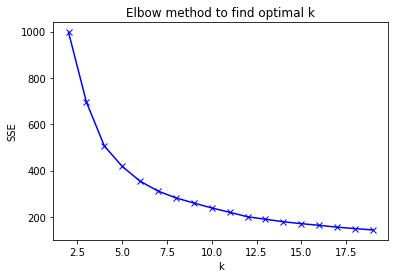

In [52]:
elbow_plot(cluster_vars = area_vars)

So let's create our clusters. 

In [56]:
k = 6

def run_kmeans(k, cluster_vars, cluster_col_name):
    # create kmeans object
    kmeans = KMeans(n_clusters = k, random_state = 13)
    kmeans.fit(X_train_scaled[cluster_vars])
    # predict and create a dataframe with cluster per observation
    train_clusters = \
        pd.DataFrame(kmeans.predict(X_train_scaled[cluster_vars]),
                              columns=[cluster_col_name],
                              index=X_train.index)
    
    return train_clusters, kmeans

In [58]:
train_clusters, kmeans = run_kmeans(k=6, 
                                    cluster_vars = ['latitude', 
                                                    'longitude', 
                                                    'age'], 
                                    cluster_col_name = 'area_cluster')

In [41]:
X_train_scaled.head()

,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio,cola
36898,0.000000,0.174269,0.554034,0.508691,0.644928,0.206452,0.011623,0.067903,0.053373,0.571429,0.0
35746,0.166667,0.421637,0.500068,0.328335,0.355072,0.230711,0.030375,0.240860,0.057033,0.250000,1.0
35707,0.166667,0.244298,0.904261,0.571006,0.202899,0.297525,0.017466,0.071208,0.002917,0.250000,0.0
20205,0.500000,0.473830,0.723965,0.267130,0.115942,0.250070,0.013138,0.126042,0.016270,0.089286,0.0
34665,0.333333,0.276462,0.917059,0.643943,0.333333,0.398419,0.014397,0.026302,0.001612,0.214286,0.0


In [34]:
train_clusters.area_cluster.value_counts()

0    4398
2    4201
4    3210
3    3083
5    1922
1    1404
Name: area_cluster, dtype: int64

Label clusters on validate and test, as we did above for train. 

Get the centroids

In [38]:
centroid_col_names = ['centroid_' + i for i in area_vars]
centroid_col_names

centroids = pd.DataFrame(kmeans.cluster_centers_, 
             columns=centroid_col_names).reset_index().rename(columns={'index': 'area_cluster'})

In [39]:
centroids

,area_cluster,centroid_latitude,centroid_longitude,centroid_age
0,0,0.377153,0.555038,0.452510
1,1,0.593080,0.332725,0.187133
2,2,0.568983,0.351105,0.452820
3,3,0.478470,0.522572,0.659231
4,4,0.481067,0.794779,0.388720
5,5,0.871611,0.631447,0.219597


Append cluster id onto X_train & X_train_scaled, then join with the centroids dataframe. 

In [ ]:
# concatenate cluster id
X_train = pd.concat([X_train, train_clusters], axis=1)

# join on clusterid to get centroids
X_train = X_train.merge(centroids, how='left', on='area_cluster').\
                set_index(X_train.index)

In [ ]:
# concatenate cluster id
X_train_scaled = pd.concat([X_train_scaled, train_clusters], 
                           axis=1)

# join on clusterid to get centroids
X_train_scaled = X_train_scaled.merge(centroids, how='left', on='area_cluster').\
                set_index(X_train.index)

Repeat on validate and test

Now, I'd like to cluster by size. Then I will group by the two different cluster types (area/age & size) and compute summary statistics. 

In [54]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18218 entries, 36898 to 33666
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   18218 non-null  float64
 1   calculatedfinishedsquarefeet  18218 non-null  float64
 2   latitude                      18218 non-null  float64
 3   longitude                     18218 non-null  float64
 4   age                           18218 non-null  float64
 5   taxrate                       18218 non-null  float64
 6   acres                         18218 non-null  float64
 7   structure_dollar_per_sqft     18218 non-null  float64
 8   land_dollar_per_sqft          18218 non-null  float64
 9   bed_bath_ratio                18218 non-null  float64
 10  cola                          18218 non-null  int64  
 11  area_cluster                  18218 non-null  int32  
 12  centroid_latitude             18218 non-null  float64
 1

     k         sse
0    2  328.795756
1    3  218.551474
2    4  124.000578
3    5   99.422333
4    6   83.645101
5    7   70.263228
6    8   62.433945
7    9   56.056598
8   10   50.332309
9   11   46.200056
10  12   41.923265
11  13   37.911244
12  14   35.174747
13  15   33.682779
14  16   31.159080
15  17   29.133784
16  18   27.586471
17  19   26.183135


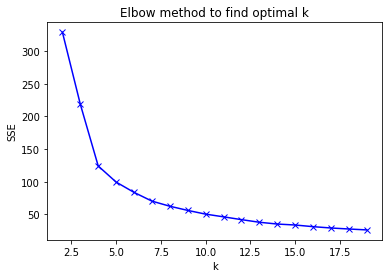

In [55]:
cluster_vars = ['calculatedfinishedsquarefeet', 'acres', 'bathroomcnt']
elbow_plot(cluster_vars)

Let's go with k = 4


In [59]:
train_clusters, kmeans = run_kmeans(k=4, 
                                    cluster_vars = cluster_vars, 
                                    cluster_col_name = 'size_cluster')

In [60]:
train_clusters.head()

,size_cluster
36898,3
35746,2
35707,0
20205,1
34665,2


## What do we do now? 

1. Explore our clusters

2. Turn clusters into features

3. Model each cluster separately

4. Turn clusters into labels